## Project 1 - Implementing CNN architectures on CIFAR 100 dataset

This notebook focuses on training CIFAR 100 dataset using Convolutional Neural Networks and it's architecture variants. <br> 

Network details:

*   Architecture: VGG16
*   Regularizer: Dropout
*   Optimizer: SGD
*   Metrics: Precision, Recall, Accuracy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(0)
random.seed(0)

### Data loading and pre-processing

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

In [ ]:
trainset = torchvision.datasets.CIFAR100(root='/drive/My Drive/Colab Notebooks/CSE 676', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR100(root='/drive/My Drive/Colab Notebooks/CSE 676', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

Extracting /drive/My Drive/Colab Notebooks/CSE 676/cifar-100-python.tar.gz to /drive/My Drive/Colab Notebooks/CSE 676
Files already downloaded and verified


In [ ]:
len(trainset), len(testset), trainset[0][0].shape

(50000, 10000, torch.Size([3, 32, 32]))

In [ ]:
classes = trainset.classes
classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


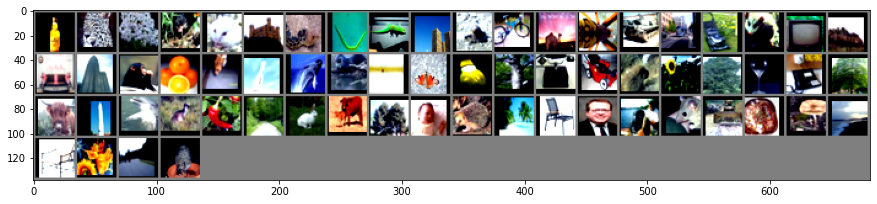

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(15,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:100], nrow=20, padding=2))

### Construct VGG-16 network

In [ ]:
# Architecture Code: https://github.com/dipuk0506/SpinalNet
class VGG(nn.Module):

    def __init__(self, features, num_class=100):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4096, num_class)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)
    
        return output

In [ ]:
def make_layers(cfg, batch_norm=False):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        if batch_norm:
            layers += [nn.BatchNorm2d(l)]
        
        layers += [nn.ReLU(inplace=True)]
        layers += [nn.Dropout2d(p=0.05)]
        input_channel = l
    
    return nn.Sequential(*layers)

In [ ]:
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# VGG-16 configuration
config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
model = VGG(make_layers(config, batch_norm=False)).to(device)

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.05, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Dropout2d(p=0.05, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Dropout2d(p=0.05, inplace=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Dropout2d(p=0.05, inplace=False)
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

### Train the model

In [ ]:
epochs = 200
patience = 10
epochs_no_improve = 0
early_stop = False
min_train_loss = np.Inf
learning_rate = 0.01
total_step = len(train_loader)

In [ ]:
accuracy_train, accuracy_test = 0, 0
train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []
test_predictions, test_labels = [], []

In [ ]:
milestone_list = [0, 10, 30, 80, 180]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestone_list, gamma=0.1, last_epoch=-1)

In [ ]:
for epoch in range(epochs):
    training_loss = 0
    train_correct = 0
    train_total = 0
    _train_loss = 0

    if epochs_no_improve == patience:
      print('Early stopped!')
      break

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        predicted = torch.max(outputs.data, 1)[1].to(device)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        accuracy_train = accuracy_train if accuracy_train > (train_correct / train_total) else (train_correct / train_total)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

    else:
        test_loss = 0
        test_correct = 0
        test_total = 0

        # Turn off gradients for validation, saves memory and computations. Test the model
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                test_labels.append(labels)
                        
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                predicted = torch.max(outputs.data, 1)[1].to(device)
                test_predictions.append(predicted)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
            
            if accuracy_test > test_correct / test_total:
                current_lr = learning_rate * np.asscalar(pow(np.random.rand(1),3))
                # update_lr(optimizer, current_lr)
            else:
                accuracy_test = test_correct / test_total
                        
            model.train()

            _train_loss = training_loss / len(train_loader)
            train_losses.append(_train_loss)
            test_losses.append(test_loss / len(test_loader))

            train_accuracy.append((train_correct / train_total) * 100)
            test_accuracy.append((test_correct / test_total) * 100)

            print("Epoch: {}/{}".format(epoch + 1, epochs), " | Training Loss: {:.3f}".format(train_losses[-1]), " | Training Accuracy: {:.3f}".format(100 * train_correct / train_total), " | Best Training Accuracy: {: .3f}".format(100 * accuracy_train),
                  " | Test Loss: {:.3f}".format(test_losses[-1]), " | Testing Accuracy: {:.3f}".format(100 * test_correct / test_total), " | Best Testing Accuracy: {: .3f}".format(100 * accuracy_test))
      
        if _train_loss < min_train_loss:
          epochs_no_improve = 0
          min_train_loss = _train_loss
        else:
          epochs_no_improve += 1

Epoch: 1/200  | Training Loss: 4.606  | Training Accuracy: 0.938  | Best Training Accuracy:  1.743  | Test Loss: 4.605  | Testing Accuracy: 1.000  | Best Testing Accuracy:  1.000
Epoch: 2/200  | Training Loss: 4.571  | Training Accuracy: 1.226  | Best Training Accuracy:  2.500  | Test Loss: 4.486  | Testing Accuracy: 1.930  | Best Testing Accuracy:  1.930
Epoch: 3/200  | Training Loss: 4.409  | Training Accuracy: 1.996  | Best Training Accuracy:  2.557  | Test Loss: 4.335  | Testing Accuracy: 2.000  | Best Testing Accuracy:  2.000
Epoch: 4/200  | Training Loss: 4.346  | Training Accuracy: 2.152  | Best Training Accuracy:  4.688  | Test Loss: 4.309  | Testing Accuracy: 2.050  | Best Testing Accuracy:  2.050
Epoch: 5/200  | Training Loss: 4.277  | Training Accuracy: 3.130  | Best Training Accuracy:  4.688  | Test Loss: 4.177  | Testing Accuracy: 3.840  | Best Testing Accuracy:  3.840
Epoch: 6/200  | Training Loss: 4.179  | Training Accuracy: 4.110  | Best Training Accuracy:  4.688  | Tes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Epoch: 7/200  | Training Loss: 4.117  | Training Accuracy: 4.696  | Best Training Accuracy:  6.250  | Test Loss: 4.075  | Testing Accuracy: 4.990  | Best Testing Accuracy:  5.070
Epoch: 8/200  | Training Loss: 4.108  | Training Accuracy: 4.914  | Best Training Accuracy:  6.250  | Test Loss: 3.964  | Testing Accuracy: 6.860  | Best Testing Accuracy:  6.860
Epoch: 9/200  | Training Loss: 3.975  | Training Accuracy: 6.574  | Best Training Accuracy:  7.812  | Test Loss: 3.890  | Testing Accuracy: 8.030  | Best Testing Accuracy:  8.030
Epoch: 10/200  | Training Loss: 3.876  | Training Accuracy: 8.148  | Best Training Accuracy:  9.688  | Test Loss: 3.776  | Testing Accuracy: 10.270  | Best Testing Accuracy:  10.270
Epoch: 11/200  | Training Loss: 3.791  | Training Accuracy: 9.722  | Best Training Accuracy:  13.542  | Test Loss: 3.702  | Testing Accuracy: 11.260  | Best Testing Accuracy:  11.260
Epoch: 12/200  | Training Loss: 3.712  | Training Accuracy: 10.916  | Best Training Accuracy:  18.

### Save and load the model

In [ ]:
weight_path='../weights'
history_path = '../model_history'

In [ ]:
torch.save(model.state_dict(), weight_path + '/VGG16_SGD_Dropout.pth')

In [ ]:
all_lists = [train_losses, test_losses, train_accuracy, test_accuracy, test_labels, test_predictions]
with open(history_path + '/VGG16_SGD_Dropout.pkl', 'wb') as f:
  pickle.dump(all_lists, f)

In [ ]:
model = VGG(make_layers(config, batch_norm=False)).to(device)
model.load_state_dict(torch.load(weight_path + '/VGG16_SGD_Dropout.pth'))

<All keys matched successfully>

In [ ]:
with open(history_path + '/VGG16_SGD_Dropout.pkl', 'rb') as f:
  all_lists = pickle.load(f)
train_losses, test_losses, train_accuracy, test_accuracy, test_labels, test_predictions = all_lists

### Model evaluation

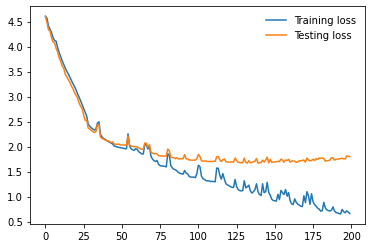

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)

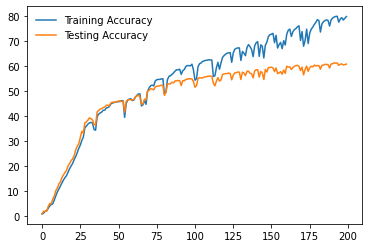

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend(frameon=False)

In [ ]:
confusion_matrix = np.zeros([100, 100], int)
label_list, prediction_list = [], []
for (labels, predictions) in zip(test_labels, test_predictions):
  for (_label, prediction) in zip(labels, predictions):
    label_list.append(_label.item())
    prediction_list.append(prediction.item())
    confusion_matrix[_label.item(), prediction.item()] += 1 

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
confusion_matrix

array([[14507,   127,   172,     0,     0,     0,    13,   147,     0,
            9,    60,    12,     0,     0,    15,     0,     6,     0,
           38,     0,    17,     0,     1,     0,    93,     5,     2,
            0,     1,     0,     0,     0,     1,     0,     7,     5,
          134,     0,     0,     1,     6,     1,     0,     6,     0,
          110,     1,     0,     1,     0,     0,     3,     0,  1054,
           73,     0,     0,   579,     5,     0,     1,     1,   273,
            0,     0,     0,     0,     0,     0,     0,   703,     0,
            0,     8,     0,     0,     0,     1,     0,     0,     0,
            1,   126,  1067,     0,     0,     0,   100,     0,     2,
            0,     1,   456,     0,    37,     0,     0,     0,    11,
            0],
       [   35, 11382,    29,     0,     0,    24,    20,     2,    63,
            5,   142,     3,     7,    42,   382,     4,    19,     2,
          400,     9,     4,    55,    21,    30,    51,   10

In [ ]:
import seaborn as sns
plt.figure(figsize=(50,50))
sns.heatmap(confusion_matrix, cmap='Blues', annot=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_list, prediction_list))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     20000
           1       0.59      0.57      0.58     20000
           2       0.41      0.37      0.39     20000
           3       0.28      0.22      0.24     20000
           4       0.31      0.29      0.30     20000
           5       0.41      0.44      0.43     20000
           6       0.51      0.52      0.51     20000
           7       0.57      0.53      0.55     20000
           8       0.57      0.52      0.54     20000
           9       0.67      0.60      0.63     20000
          10       0.38      0.25      0.30     20000
          11       0.41      0.27      0.33     20000
          12       0.55      0.54      0.54     20000
          13       0.50      0.44      0.47     20000
          14       0.37      0.34      0.36     20000
          15       0.43      0.44      0.43     20000
          16       0.52      0.46      0.49     20000
          17       0.60    

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(label_list, prediction_list, average='weighted'))

(0.4840667893203092, 0.4844255, 0.4801756936329469, None)


**Precision and recall from above classification report - 48% (weighted average)**

In [ ]:
max(test_accuracy)

61.45

**Maximum accuracy - 61.45%**

# References

#### *Dataset*
1. [CIFAR100](https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR100)

#### *Code*
1. https://github.com/dipuk0506/SpinalNet
2. https://pytorch.org/docs/stable/nn.html#convolution-layers
3. https://towardsdatascience.com/start-your-cnn-journey-with-pytorch-in-python-6f8364a79801

#### *Readings*
1. https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5
2.  https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
3. https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/14
4. http://d2l.ai/chapter_convolutional-neural-networks/index.html
5. http://cs231n.stanford.edu/
6. https://arxiv.org/pdf/1409.1556.pdf